# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [36]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, isnull, udf, last, first, struct, lit
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [37]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()
# Reduce number of partitions to only 5 to easily deal with small dataset
# as suggested at https://stackoverflow.com/questions/55721767/spark-streaming-job-is-running-very-slow
spark.conf.set("spark.sql.shuffle.partitions", 5)

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [38]:
# Define path to the mini data set used for initial steps and load this data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [39]:
# Display data schema to get an idea of what the data looks like
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Looking at the schema we can observe that there is a total of 18 columns of which 12 are strings. Even out of those variables that are not strings only length really seems to be a classical numerical variable. One could perhaps also include the timestamp ("ts"), but as a data it should be dealt with differently than a quantitative variable. As for the other variables that are not integers, they really just represent some sort of ID and can therefore not be interpreted as numbers.

So, overall it seems as though we are dealing with mainly categorical variables.This will have certain implications later on once we deal with feature engineering. 

Let us also briefly note that there are some columns such as a user's first name where it is almost immediately obvious that they will most likely not help us with predicting user churn rates. We may thus be able to drop some columns later on.

In [40]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

## Looking for and Dealing with NANs
As a first step, let us have a look at how much data is actually missing and think about which columns are so critical that a missing value should lead to the exclusion of an observation.
The "userId" and the "ts" (timestamp) column may perhaps be the two most critical columns since these two columns ensure the integrity of an entry. Similarly, the 'sessionId' column should not have a missing value either.

In [41]:
# Used both isnan and isnull PySpark SQL functions as suggested at 
# https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
user_log.select([count(when(isnan(c), c)).alias(c) for c in user_log.columns]).show()
user_log.select([count(when(isnull(c), c)).alias(c) for c in user_log.columns]).show()
# Also look for cases with empty strings
user_log.select([count(when(col(c)=='', c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAge

In [42]:
# Have a closer look at the missing values
# For cases where we have no first name we would expect users not to be registered and hence to have no user ID
user_log.filter(isnull(user_log.firstName)).select('registration').dropDuplicates().show()
user_log.filter(isnull(user_log.firstName)).select('userId').dropDuplicates().show()
# For cases where there is no information on the artist or the song check if people were doing other things
# than listening to a song
user_log.filter(isnull(user_log.artist)).select('page').dropDuplicates().show(30, False)

+------------+
|registration|
+------------+
|        null|
+------------+

+------+
|userId|
+------+
|      |
+------+

+-------------------------+
|page                     |
+-------------------------+
|Downgrade                |
|Thumbs Down              |
|Login                    |
|About                    |
|Cancel                   |
|Add to Playlist          |
|Thumbs Up                |
|Home                     |
|Error                    |
|Save Settings            |
|Submit Downgrade         |
|Cancellation Confirmation|
|Register                 |
|Submit Registration      |
|Logout                   |
|Add Friend               |
|Settings                 |
|Roll Advert              |
|Help                     |
|Upgrade                  |
|Submit Upgrade           |
+-------------------------+



It turns out that there are two cases of missing values:
* 8346 rows of unregistered users (the "userId" column is empty and there is no personal user information,
i.e. first/ last name and gender available)
* 58,392 rows where users are not listening to a song and there is hence no song related information

As for the former, it seems reasonable to simply drop these rows since we only care about the churn of existing users. On the other side, missing song data is by no means a dealbreaker since in all cases where people are not listening to a song, we would not expect to get any song related information anyway.

In [43]:
# Drop rows with unregistered users
user_log = user_log.where(user_log.userId != '')

## Number of Observations and Distribution of Number of Interactions

In [10]:
# Explore dimensions after dropping NANs
num_obs = user_log.count()
num_cols = len(user_log.columns)
print('Number of observations: {}'.format(num_obs))
print('Number of columns:{}'.format(num_cols))
# Have a look at the number of unique user IDs and the average number of interactions per user ID
num_users = user_log.select('userId').dropDuplicates().count()
print('Number of unique users: {}'.format(num_users))
print('Average number of interactions per user {}'.format(num_obs/num_users))

Number of observations: 278154
Number of columns:18
Number of unique users: 225
Average number of interactions per user 1236.24


It turns out that what initially seemed like a rather larger data set is not that large because there were on average about 1236 interactions per user. Hence, the 278,154 interactions represent really just data of 225 unique users.  

Ultimately we want to use the log data to predict churn rates of individual users. Hence, we will ultimately need to aggregate the user log data at the user ID level to be able predict churn rates when we turn towards feature engineering and prediction. In this sense, we should probably think of the number of unique users as being more representative of our sample size.

Even so, it is also true that the more interactions we have recorded for each user the better we should be able to predict whether they will churn or not.

Next, let us have a brief look at how the number of interactions is distributed across the 225 unique users. 

Median number of interactions per user: 848.0
Standard deviation of interactions per user: 1329.531716432519
Minimum number of interactions for a single user: 6
Maximum number of interactions for a single user: 9632


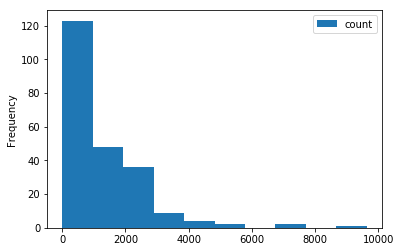

In [11]:
# Create a pandas dataframe with the distribution of the number of interactions and plot it
interactions_df = user_log.groupBy('userId').count().toPandas()
interactions_df.plot.hist()
print('Median number of interactions per user: {}'.format(interactions_df['count'].median()))
print('Standard deviation of interactions per user: {}'.format(interactions_df['count'].std()))
print('Minimum number of interactions for a single user: {}'.format(interactions_df['count'].min()))
print('Maximum number of interactions for a single user: {}'.format(interactions_df['count'].max()))

We can see that there is quite a lot of variability with respect to the number of interactions per user. This was probably to be expected. There will usually be some users who won't use  a service too much while others may actually be power users. As long as we have some interactions and as long as this difference in usage intensity is later on somehow reflected in our features, we will probably be fine.

Let us also have a brief look at gender and page to get a better overview of the collected data.

## Distribution of Gender and Page Accesses (Use of Different Functions of Service)

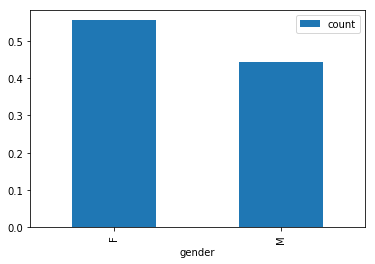

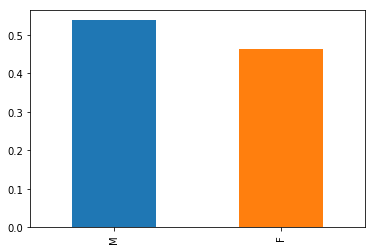

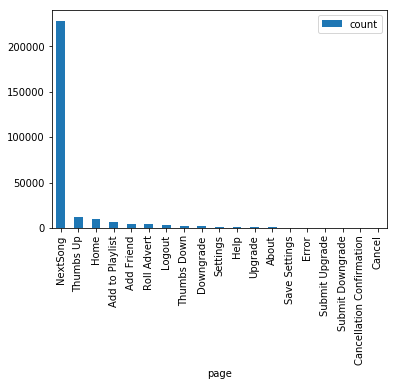

In [12]:
# Look at gender distribution in overall data, i.e. interactions
# I am using relative shares here for an easier comparison with the second case
# where gender distribution by user is plotted
gender_interaction_df = user_log.groupBy('gender').count().toPandas()
gender_interaction_df['count'] = gender_interaction_df['count']/num_obs
gender_interaction_df.plot.bar(x = 'gender')
plt.show()
# Look at gender distribution by user, i.e. how many users identified as male, female or did not provide an answer?
gender_user_df = user_log.groupBy('userId', 'gender').count().toPandas()
gender_user_df = gender_user_df['gender'].value_counts(normalize = True, dropna = False)
gender_user_df.plot.bar(x=gender_user_df.index)
plt.show()
# Have a look at how many interactions could be attributed to the different kinds of pages
# visited by users
page_df = user_log.groupBy('page').count().toPandas()
page_df.sort_values(by = 'count', ascending = False).plot.bar(x = 'page')

## Observations for Gender
Looking at the distribution of genders, we can see that while the share of women in overall interactions with Sparkify were larger (53.95%) while their share in users (46.02%) was actually smaller than that of men. This suggests that gender may be an interesting feature to consider later on. With that said, there does not seem be a huge imbalance in gender in the data regardless of which level we look at.

## Observations for Page
By far the most common interaction was "NextSong", i.e. users choosing a song to listen to. Given that Sparkify is a music streaming service this was probably to be expected, but it is still interesting to see how other activities like accessing the homepage of the service, giving a thumbs up for a song, adding songs to a playlist or adding friends happen much less frequently than playing back a song. 

## Distribution of Dates

Finally, before defining churn and looking at how users who have churned differ from those who have not, let us have a brief look at the distribution of dates in the data. To simplify things, I decided to simply look at year and month.

In [13]:
# Convert timestamps to year-month and save this in a new column 
ts_to_year_month = udf(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m'))
user_log = user_log.withColumn('year_month',ts_to_year_month(user_log.ts))

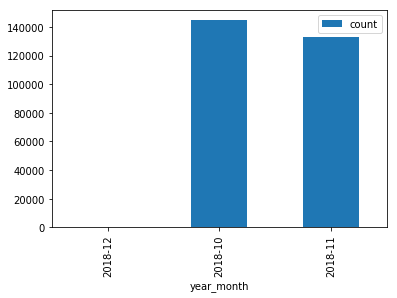

In [14]:
# Obtain pandas dataframe containing counts of year-month combinations and plot the result
year_month_df = user_log.groupBy('year_month').count().toPandas()
year_month_df.plot.bar(x = 'year_month')
plt.show()

It turns out that the Sparkify log data consists essentially of data collected in October 2018 and November 2018 in almost equal proportions (144,707 and 133,288 rows, respectively). There are also about 159 observations for December 2018.

In general, the more data we have the better, but overall user behaviour and preferences may change over time. Hence, if we were to use data collected over e.g. 5 years we would probably need to somehow account for these changes. In addition to this, changes in the service itself such as a new UI or changes in the content available may also cause data not to be comparable anymore. In fact, such changes could be the very reason for users to churn.

On the other hand, if the time period covered by our data is too short, this may also have a detrimental effect on the predictive power of our model. With this small dataset covering mostly only two months' worth of data, it could very well be possible that a lot of users only become tired of the service after three months or perhaps half a year.

Ultimately, while the data for this project was provided, in real life it could probably be rather important to think about how long the time period covered by the data should be.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Defining Churn

Before we can move on to comparing users who churned and those who did not, we first need to think about what we would define as churning. A narrow definition would probably only include people who have deleted their account which is captured in our data as cases where the page feature takes on the value "Cancellation Confirmation", i.e. cases where people delete their account. This can happen for both users using the free or the paid version of the streaming service.

If we take on a broader view, we could also think of users switching from the paid to the free service as some sort of churning. Both leaving the service It turns out that identifying these users is a bit more complicated. While a user can only cancel their registration once, it is very much possible for a customer to downgrade from the paid to the free service and to then upgrade to the paid service again or to even repeat this cycle. Ultimately, it seems most reasonable to only include people who have downgraded their account at least once in the observed time period in our data and whose level for the observation with the most recent time stamp was "free".

The question then is whether these two kinds of churning should be regarded as identical or whether we should really think of this as a multiclass-classification problem instead of a binary classification problem. Ideally, we should conduct a survey with users who canceled their registration and those who only switched from the paid to the free version of the service to gain some insights as to whether they are similar or quite different. This is obviously unfortunately not possible for this project. I would argue that, if anything, there is a qualitative difference between someone who actually deletes their account and someone who chooses to just downgrade their account from paid to free. At the same time, it is also true that in both cases there must have been some sort of dissatisfaction. Given the small number of both kinds of churning and to simplify the problem, I decided not to differentiate between these two cases.

Finally, strictly speaking defining churn by just accounting for these two cases will quite likely underestimate actual churn rates. There may be users who perhaps never used the paid service and who stopped using the service, but never bothered to cancel their registration. Given that the data we have here only covers about two months, it is probably not reasonable to try to cover this problem, but it is certainly a point worth keeping in mind.

In [44]:
# Identify users who canceled their registration
flag_cancel = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
user_log = user_log.withColumn('cancel_page',flag_cancel('page'))
windowval = Window.partitionBy('userId')
user_log = user_log.withColumn('canceled',Fsum('cancel_page').over(windowval))

In [45]:
# Check if values of canceled column are as expected, i.e. either 0 or 1
user_log.select('canceled').dropDuplicates().show()

+--------+
|canceled|
+--------+
|       0|
|       1|
+--------+



In [46]:
# Display number of unique user IDs who canceled their registration
user_log.filter(user_log.canceled == 1).select('userId').dropDuplicates().count()

52

In [47]:
# Create column with number of downgrades for each user ID
flag_downgrade = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
user_log = user_log.withColumn('downgrade_page', flag_downgrade('page'))
user_log = user_log.withColumn('num_downgrades',Fsum('downgrade_page').over(windowval))

In [48]:
# Create a column to keep track of a user's level, i.e. whether they are using the paid or free service, at the last recorded
# timestamp for that user using approach found at 
# https://stackoverflow.com/questions/50468056/get-the-last-value-using-spark-window-function
window_level = Window.partitionBy("userId").orderBy("ts").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
user_log = user_log.withColumn('final_level',last('level').over(window_level))
# Using this information identify those users who downgraded and actually stayed at the free tier
# making use of approach described at https://stackoverflow.com/questions/42540169/pyspark-pass-multiple-columns-in-udf
flag_downgrade_churn = udf(lambda x: 1 if (x[0] > 0)&(x[1] == 'free') else 0, IntegerType())
user_log = user_log.withColumn('downgraded_churn', flag_downgrade_churn(struct('num_downgrades','final_level')))
# Finally, create a column indicating whether a user churned (either by canceling their registration or by downgrading and
# remaining at the free tier level)
# TO DO: Briefly define a function here to map canceled to 1, downgraded to 2 and stayed to 0! 
flag_churned = udf(lambda x: 1 if (x[0] == 1)|(x[1] == 1) else 0, IntegerType())
user_log = user_log.withColumn('churned',flag_churned(struct('canceled','downgraded_churn')))

In [49]:
# Have a short look at the first observation to run the steps from above (lazy evaluation) and to also check
# that the new columns were created as expected
user_log.head()

Row(artist='Sea Wolf', auth='Logged In', firstName='Brycen', gender='M', itemInSession=0, lastName='Bradley', length=265.53424, level='paid', location='Laurel, MS', method='PUT', page='NextSong', registration=1538159495000, sessionId=9, song='Ses Monuments', status=200, ts=1538965220000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', cancel_page=0, canceled=0, downgrade_page=0, num_downgrades=0, final_level='paid', downgraded_churn=0, churned=0)

## Exploring Data: Comparing Users Who Churned and Those Who Did Not

Now that we have defined churn and identified those users who churned, we should have a look at some features and how their distribution differs across the two groups of users: those who churned and those who did not.

In order to avoid potential issues and to also avoid repetition by having to apply all subsequent operations to two dataframes let us not create two different Pyspark dataframes, but rather perform the filtering later on when creating Pandas dataframes for our visualisations. 

In [50]:
# Drop columns we may not need anymore
user_log = user_log.drop(*['final_level','cancel_page','downgrade_page', 'num_downgrades'])
# Have a look at how many users have churned and how many have not
print('Number of users who have churned {}'.\
      format(user_log.filter(user_log.churned == 1).select('userId').dropDuplicates().count()))
print('Number of users who have not churned {}'.\
      format(user_log.filter(user_log.churned == 0).select('userId').dropDuplicates().count()))

Number of users who have churned 67
Number of users who have not churned 158


### Comparing the Two Groups
Now that we have created two separate dataframes, let us think about some measures we might be interested in. It seems reasonable to assume that users who churned used the service differently than those who did not. It may thus make sense to define some aggregate measures and compare their distributions across the two groups of users.

If we want to figure out how active the different kinds of users were, we need to think about what we would consider an appropriate time period to use as our yardstick. One possible approach would be to consider how much a user did during a single session. Alternatively, we could simply look at the entire time period for which we have data for a particular user and then look at e.g. how many songs they listened to (e.g. on average per hour or day) or how many times they decided to give a thumbs up (again relative to some time unit such as an hour or a day). It turns out that this is not an ideal approach either because a user who e.g. listened to a lot of songs on just a single day would appear to have been very active. Instead, it seems more appropriate to simply count how many times users performed a certain action during a certain period of time. I decided to look at how many times users performed a certain action during the first two weeks recorded in the data available

In summary, I decided to look at the following aggregated metrics:
+ how many songs users listened to during the first two weeks in the data available for them
+ how many times users gave a thumbs up during the first two weeks in the data available for them
+ how many times users added something to a playlist during the first two weeks in the data available for them
+ how many times users added a friend during the first two weeks in the data available for them

### Short Overview of Approach Taken for Calculating Aggregate Measures
In order to obtain the first two weeks during which a user was active according to our data, we need to look at first and subtract it from the timestamp recorded for a particular action. We can then calculate the number of seconds between the two timestamps and use this to derive a dummy variable indicating whether an observation occured within the first two weeks for which we have observations for the respective user. We can then count the instances where a user performed a certain action such as listening to during the first two weeks for which data is available for them.  

It should also be briefly mentioned that due to different song lengths, the number of songs is not necessarily a perfect measure, but overall it should be close enough.

In [51]:
# Take similar approach as above to obtain first value of timestamp for each user ID, can hence use
# window_level window defined above
user_log = user_log.withColumn('first_ts',first('ts').over(window_level))
# Use the difference between the first timestamp and the current one to calculate how much time has passed
def ts_diff_func(ts_struct):
    '''
    Calculates difference between timestamps contained in two columns contained in a PySpark dataframe
    INPUT:
        ts_struct - PySpark struct containing the two columns used for calculating the timestamp difference
    OUTPUT:
        ts_diff_week_fract - difference between the two time stamps in fractions of a week
    '''
    ts_diff_week_fract = (datetime.fromtimestamp(ts_struct[1]/1000) - datetime.fromtimestamp(ts_struct[0]/1000)).\
                         seconds/(24*7*3600)
    return ts_diff_week_fract
# Turn into UDF
ts_diff_udf = udf(ts_diff_func, DoubleType())
user_log = user_log.withColumn('ts_diff_weeks',ts_diff_udf(struct('first_ts','ts')))
user_log.head()

Row(artist='Sea Wolf', auth='Logged In', firstName='Brycen', gender='M', itemInSession=0, lastName='Bradley', length=265.53424, level='paid', location='Laurel, MS', method='PUT', page='NextSong', registration=1538159495000, sessionId=9, song='Ses Monuments', status=200, ts=1538965220000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', canceled=0, downgraded_churn=0, churned=0, first_ts=1538965220000, ts_diff_weeks=0.0)

Now that we have verified that we have indeed created a column containing the difference in fractions of weeks between the first and the current timestamp for each observation of a user, we can calculate how many times each user has performed a certain activity in their first two weeks.

In [52]:
# Create a new column indicating that a timestamp was in the first two weeks of a user's activities and also
# one of the most common different activities
# Using the same approach as above, add flags for different activities and sum up values
# Also adding parameter to udf as described at 
# https://stackoverflow.com/questions/47260999/how-to-pass-the-parameter-to-user-defined-function
flag_activity = udf(lambda columns, activity: 1 if (columns[0] == activity) & (columns[1] <= 2.0) else 0, IntegerType())

# Create list containing names of new  flag columns to be created
flag_cols = ['song', 'thumbs_up', 'add_playlist', 'add_friend']
activities_list = ['NextSong','Thumbs Up', 'Add to Playlist','Add Friend']

# Create the respective flag columns and calculate sums
# Again using approach as found at 
# https://stackoverflow.com/questions/47260999/how-to-pass-the-parameter-to-user-defined-function
# to pass in parameter to udf by defining a column containing a constant value -> lit(activity)
for activity,col_name in zip(activities_list, flag_cols):
    user_log = user_log.withColumn(col_name+'_flag', flag_activity(struct('page','ts_diff_weeks'), lit(activity)))

for col in flag_cols:    
    user_log = user_log.withColumn(col+'_num', Fsum(col+'_flag').over(windowval))

user_log.head()

Row(artist='Sea Wolf', auth='Logged In', firstName='Brycen', gender='M', itemInSession=0, lastName='Bradley', length=265.53424, level='paid', location='Laurel, MS', method='PUT', page='NextSong', registration=1538159495000, sessionId=9, song='Ses Monuments', status=200, ts=1538965220000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', canceled=0, downgraded_churn=0, churned=0, first_ts=1538965220000, ts_diff_weeks=0.0, song_flag=1, thumbs_up_flag=0, add_playlist_flag=0, add_friend_flag=0, song_num=673, thumbs_up_num=37, add_playlist_num=9, add_friend_num=12)

As the next step let us move the data for these new metrics to pandas dataframes and visualise so we can find out how they differ across the two kinds of users.

In [53]:
# create a pandas dataframe for each user group containing the avg measures we are interested in
avg_churned_df = user_log.filter((user_log.churned == 1)).\
                 select('userId','song_num','thumbs_up_num','add_playlist_num','add_friend_num','gender','downgraded_churn').\
                 dropDuplicates().toPandas()
avg_churned_nodg = avg_churned_df[avg_churned_df['downgraded_churn'] == 0]
avg_not_churned_df = user_log.filter(user_log.churned == 0).\
                     select('userId','song_num','thumbs_up_num','add_playlist_num','add_friend_num','gender','downgraded_churn').\
                     dropDuplicates().toPandas()


In [ ]:
avg_not_churned_df['song_avg'].hist()

In [54]:
for col in ['song_num','thumbs_up_num','add_playlist_num','add_friend_num']:
    print('median for '+str(col)+' for churned users : '+str(avg_churned_df[col].median()))
    print('median for '+str(col)+' for churned users wo downgrades : '+str(avg_churned_nodg[col].median()))
    print('median for '+str(col)+ ' for users who have not churned: '+ str(avg_not_churned_df[col].median()))

median for song_num for churned users : 530.0
median for song_num for churned users wo downgrades : 417.0
median for song_num for users who have not churned: 711.0
median for thumbs_up_num for churned users : 28.0
median for thumbs_up_num for churned users wo downgrades : 19.0
median for thumbs_up_num for users who have not churned: 41.0
median for add_playlist_num for churned users : 14.0
median for add_playlist_num for churned users wo downgrades : 11.0
median for add_playlist_num for users who have not churned: 20.0
median for add_friend_num for churned users : 13.0
median for add_friend_num for churned users wo downgrades : 11.0
median for add_friend_num for users who have not churned: 15.0


In [55]:
for col in ['song_num','thumbs_up_num','add_playlist_num','add_friend_num']:
    print('mean for '+str(col)+' for churned users : '+str(avg_churned_df[col].mean()))
    print('mean for '+str(col)+' for churned users wo downgrades : '+str(avg_churned_nodg[col].mean()))
    print('mean for '+str(col)+ ' for users who have not churned: '+ str(avg_not_churned_df[col].mean()))

mean for song_num for churned users : 836.1940298507462
mean for song_num for churned users wo downgrades : 704.063829787234
mean for song_num for users who have not churned: 1089.132911392405
mean for thumbs_up_num for churned users : 41.6865671641791
mean for thumbs_up_num for churned users wo downgrades : 36.276595744680854
mean for thumbs_up_num for users who have not churned: 61.75949367088607
mean for add_playlist_num for churned users : 24.26865671641791
mean for add_playlist_num for churned users wo downgrades : 20.319148936170212
mean for add_playlist_num for users who have not churned: 31.0126582278481
mean for add_friend_num for churned users : 15.208955223880597
mean for add_friend_num for churned users wo downgrades : 12.787234042553191
mean for add_friend_num for users who have not churned: 20.620253164556964


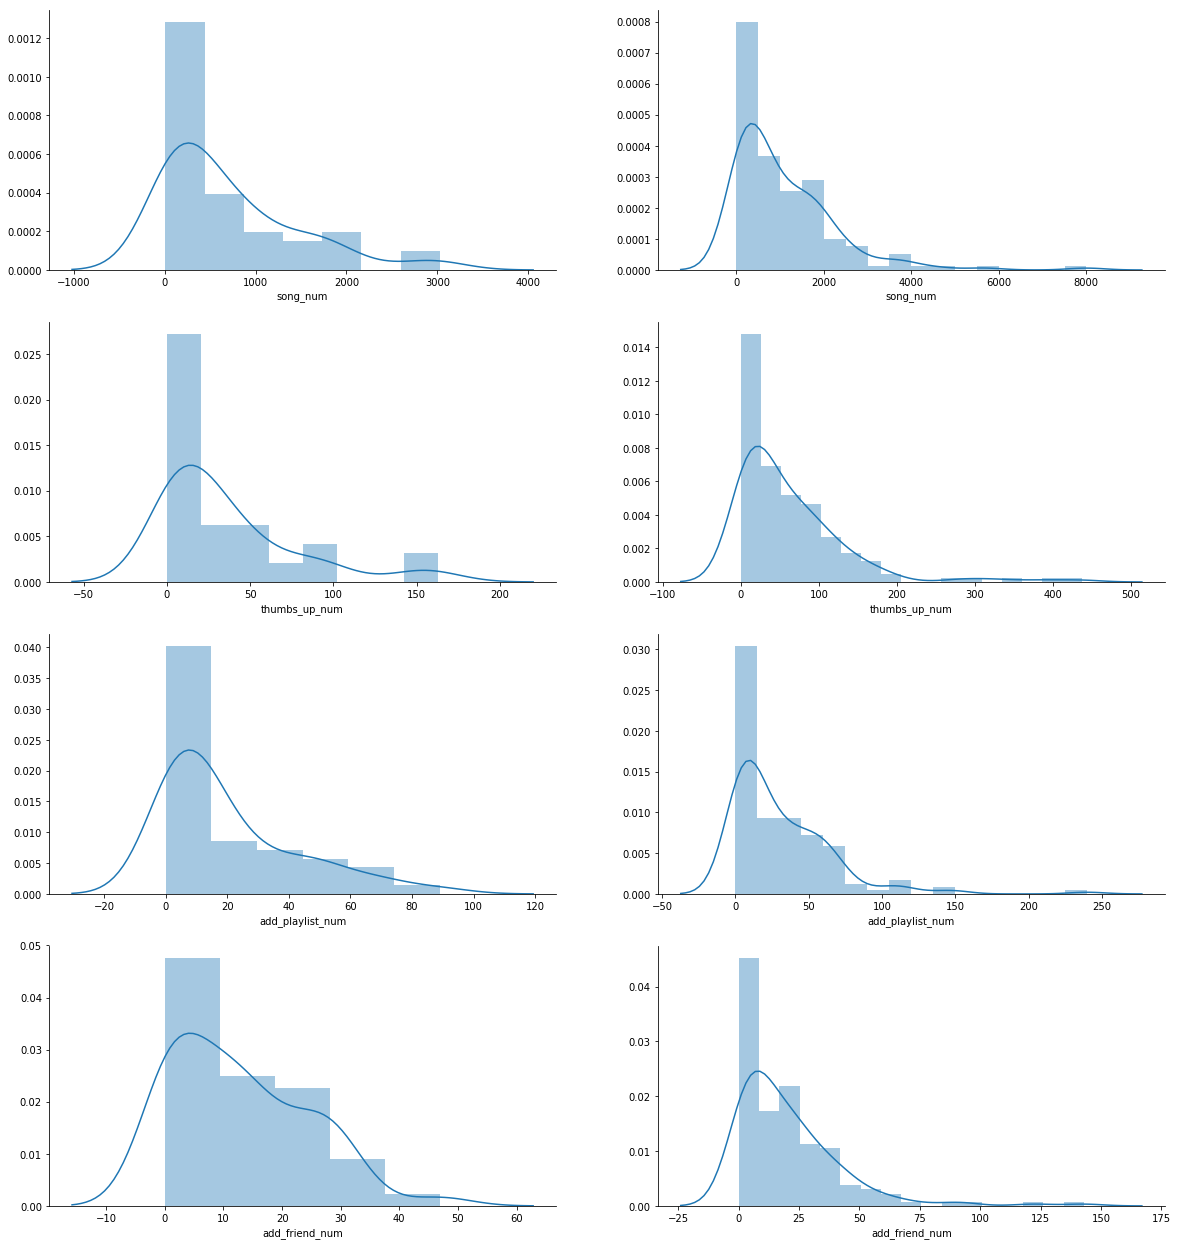

In [59]:
# create plots to compare the distributions
i = 0
base_colour = sns.color_palette()[0]
plt.figure(figsize = (20,22))

for col in ['song_num','thumbs_up_num','add_playlist_num','add_friend_num']:
    plt.subplot(4, 2, i+1)
    plt_churned = sns.distplot(avg_churned_nodg[col].dropna(), norm_hist = True, hist = True, color = base_colour)
    sns.despine(right=True,top=True)
    plt.subplot(4, 2, i+2)
    plt_not_churned = sns.distplot(avg_not_churned_df[col].dropna(), norm_hist = True, hist = True, color = base_colour)
    sns.despine(right=True,top=True)
    i+=2

In [ ]:
 plt.subplot(4, 2, i+1)
    plt_churned = avg_churned_nodg['gender'].value_counts().plot(color = base_colour)
    plt.subplot(4, 2, i+2)
    plt_not_churned = sns.distplot(avg_not_churned_df[col].dropna(), norm_hist = True, hist = True, color = base_colour)
    sns.despine(right=True,top=True)

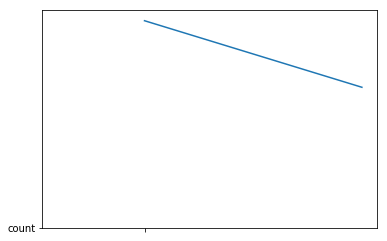

In [63]:
plt_churned = avg_churned_nodg['gender'].value_counts().plot(color = base_colour).bar(x='index',height = 'count')

In [65]:
print(avg_churned_nodg['gender'].value_counts(normalize = True))
print(avg_not_churned_df['gender'].value_counts(normalize = True))

M    0.595745
F    0.404255
Name: gender, dtype: float64
M    0.518987
F    0.481013
Name: gender, dtype: float64


Insert comment on findings and talk about how to use these for feature engineering; perhaps also look at a few other features such as gender!

Now, some of the columns have names which are perhaps not quite as self-explanatory as ts or sessionID. It may thus make sense to have a short look at the unique values of these variables to get a better understanding of what they really represent.

In [ ]:
# Have a closer look at distinct values of some not self-explanatory columns
for column in ['auth', 'itemInSession','level', 'location', 'method', 'registration','status','userAgent']:
    user_log.select(column).distinct().show()


Before we move on to defining our target variable and then feature engineering for our machine learning model, it may be interesting to have a look at some variables and their distributions.

Some obvious choices here are gender, page and userID. If we observe certain imbalances we should at least take note of them and cases such as gender try to deal with them.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.